In [1]:
%load_ext zipline
%matplotlib inline
%config InlineBackend.figure_format = 'png'

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Entire data start date: 2013-01-02
Entire data end date: 2016-12-30
Backtest months: 48


,Backtest
Annual return,13.1%
Cumulative returns,63.8%
Annual volatility,13.0%
Sharpe ratio,1.02
Calmar ratio,1.01
Stability,0.83
Max drawdown,-12.9%
Omega ratio,1.19
Sortino ratio,1.46
Skew,-0.24


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.94,2015-07-16,2015-08-25,2016-03-11,172
1,9.13,2016-04-01,2016-06-27,2016-11-29,173
2,7.70,2013-12-31,2014-02-03,2014-06-18,122
3,7.31,2014-09-18,2014-10-16,2014-10-31,32
4,5.43,2014-12-29,2015-01-30,2015-02-12,34


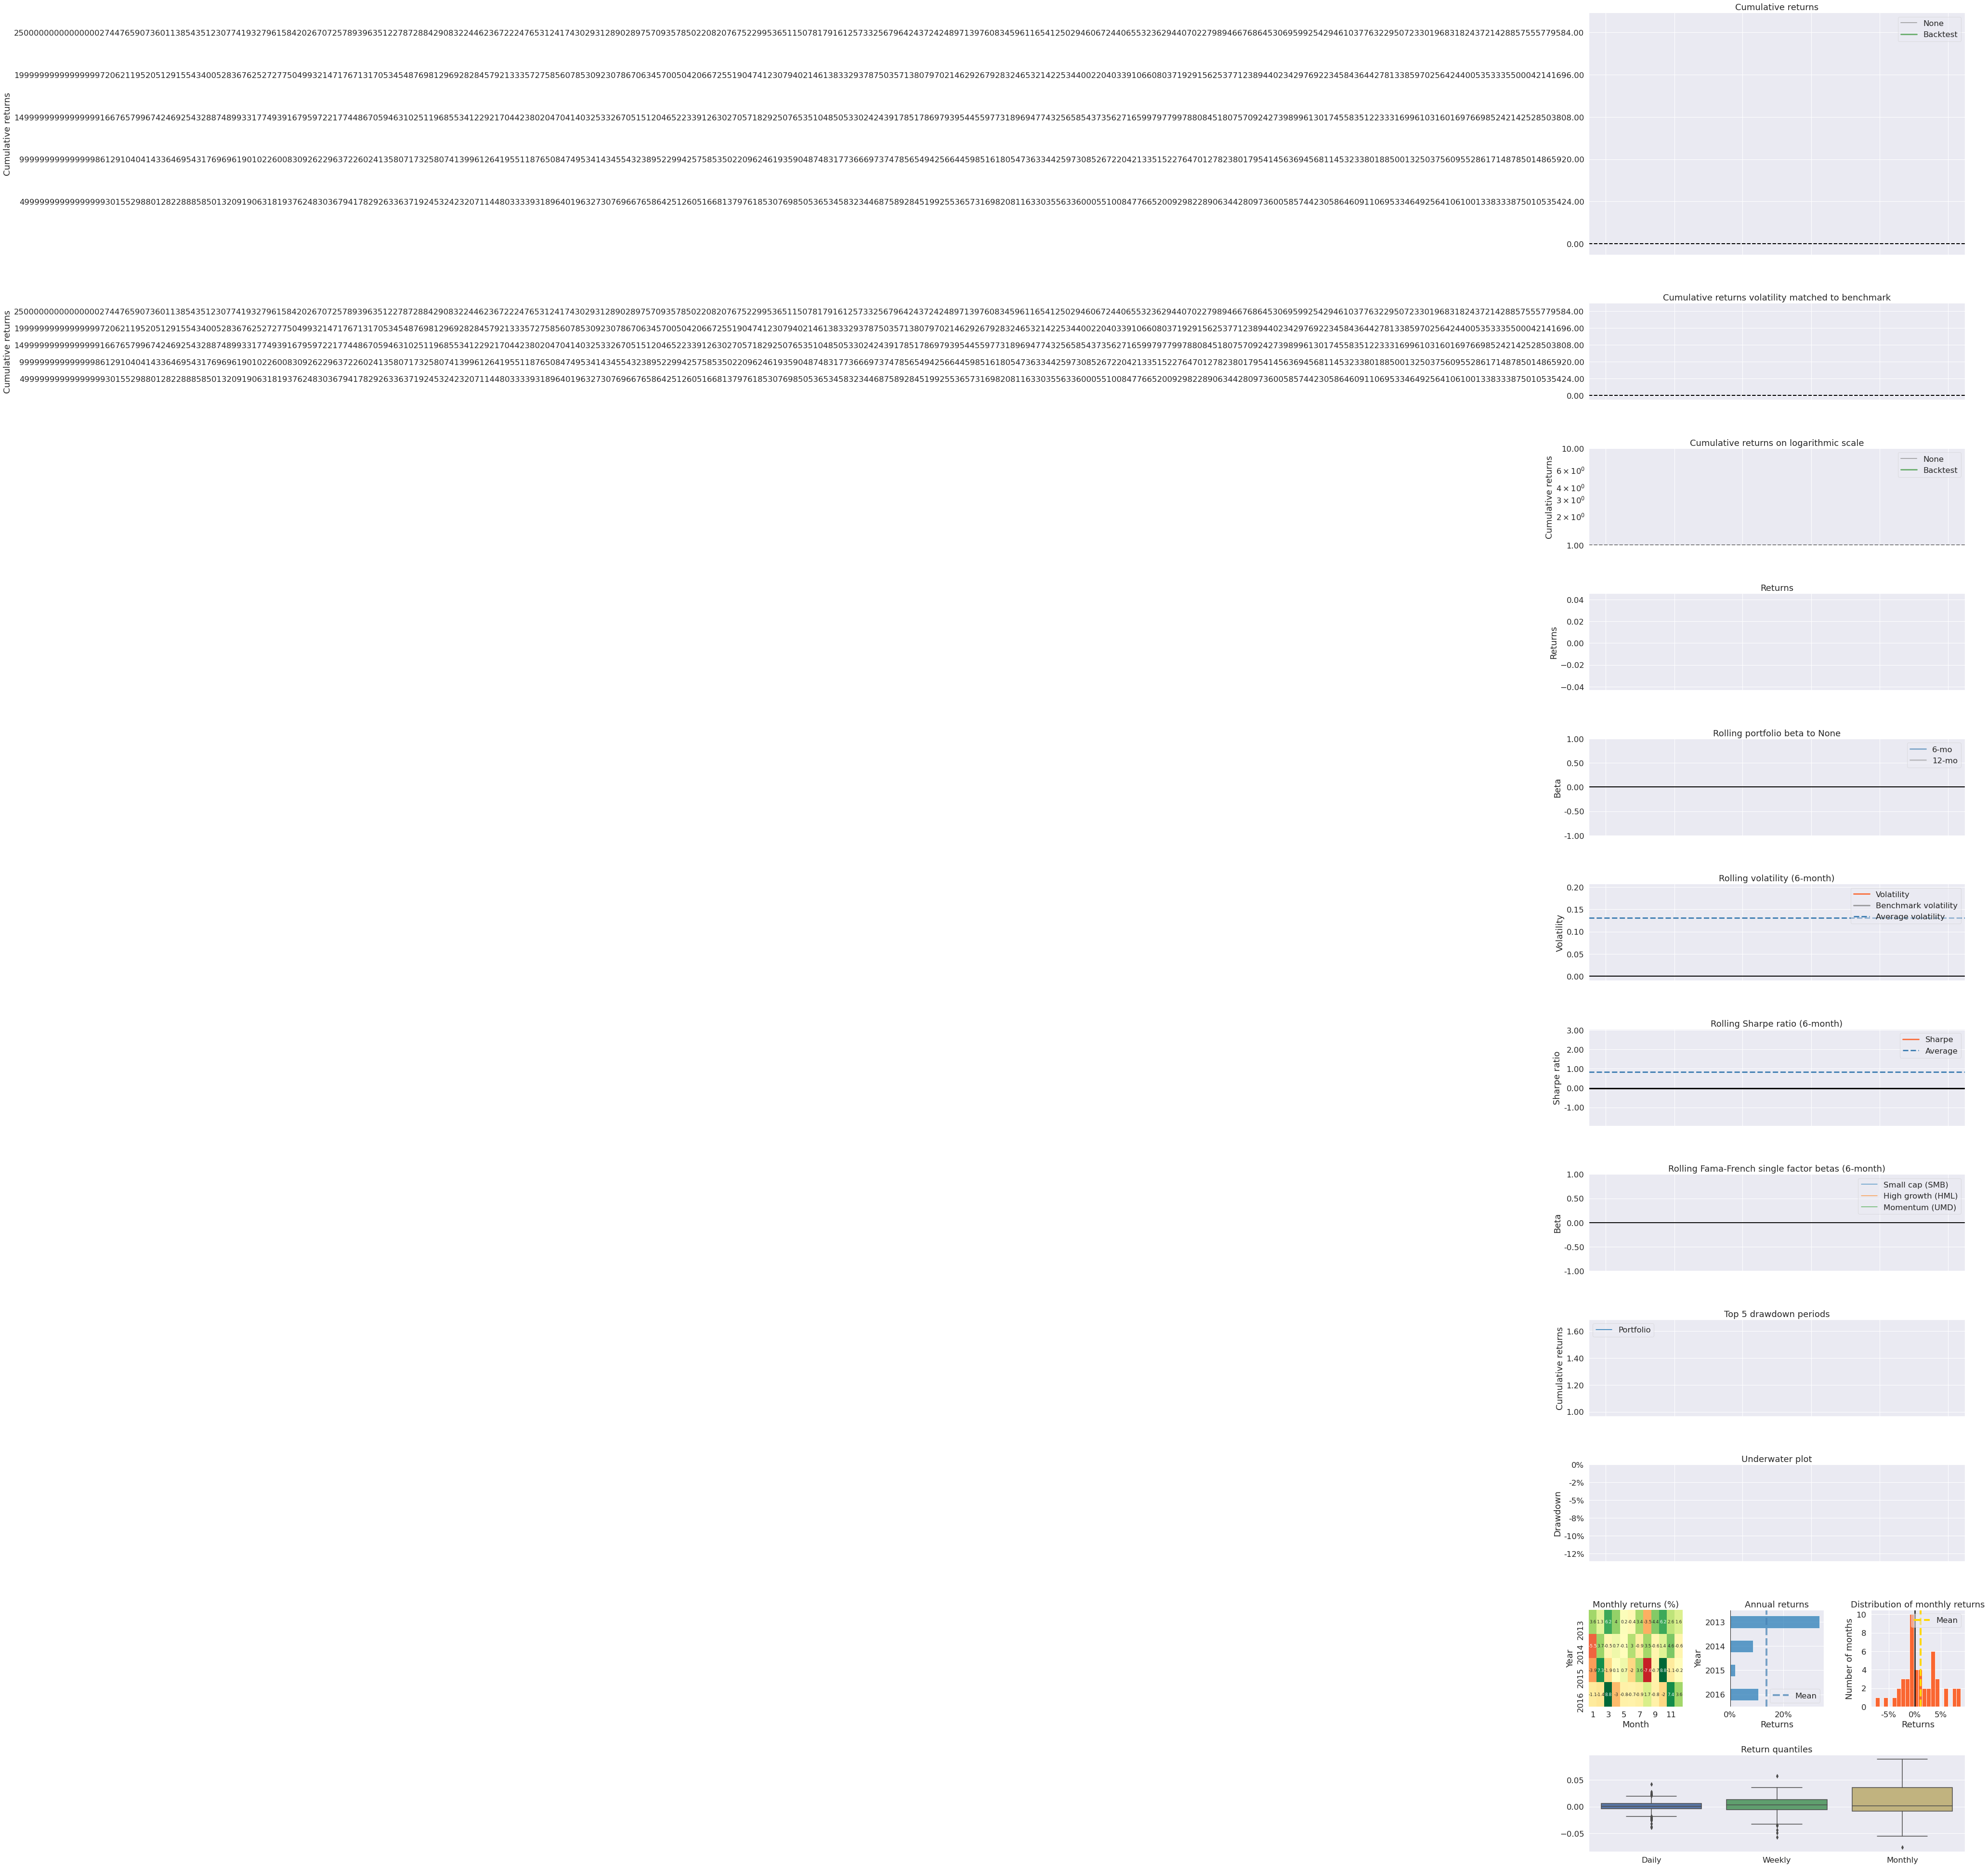

Stress Events,mean,min,max
Apr14,0.00%,-1.79%,0.85%
Oct14,0.07%,-1.71%,1.60%
Fall2015,-0.20%,-3.93%,4.15%
New Normal,0.05%,-3.93%,4.15%


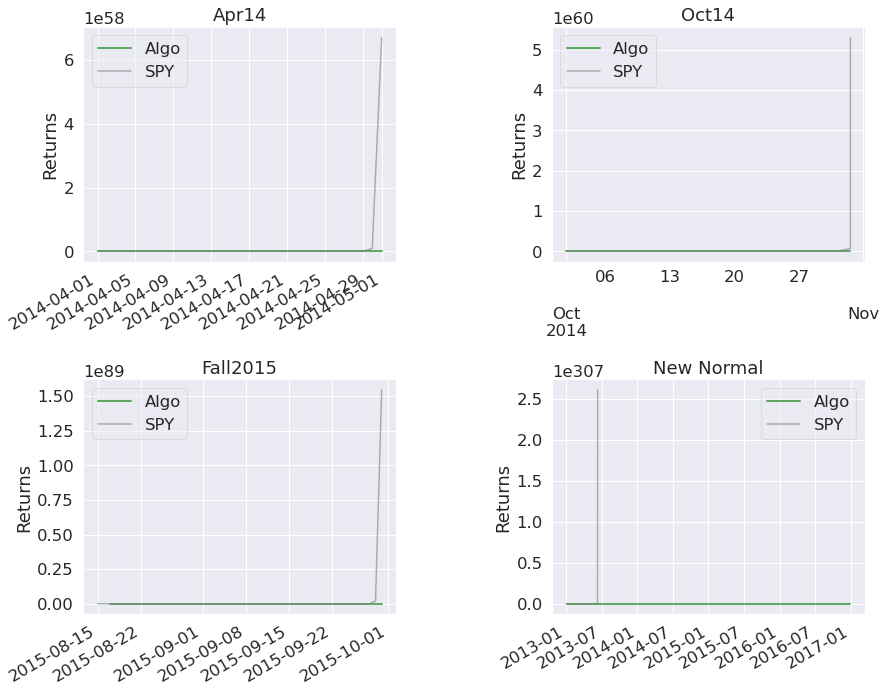

Top 10 long positions of all time,max
GS,11.69%
WBA,11.56%
AAPL,11.34%
NKE,11.29%
UNH,11.25%
CVX,11.23%
INTC,11.13%
MSFT,11.08%
CAT,11.06%
VZ,11.01%


Top 10 short positions of all time,max


Top 10 positions of all time,max
GS,11.69%
WBA,11.56%
AAPL,11.34%
NKE,11.29%
UNH,11.25%
CVX,11.23%
INTC,11.13%
MSFT,11.08%
CAT,11.06%
VZ,11.01%


All positions ever held,max
GS,11.69%
WBA,11.56%
AAPL,11.34%
NKE,11.29%
UNH,11.25%
CVX,11.23%
INTC,11.13%
MSFT,11.08%
CAT,11.06%
VZ,11.01%


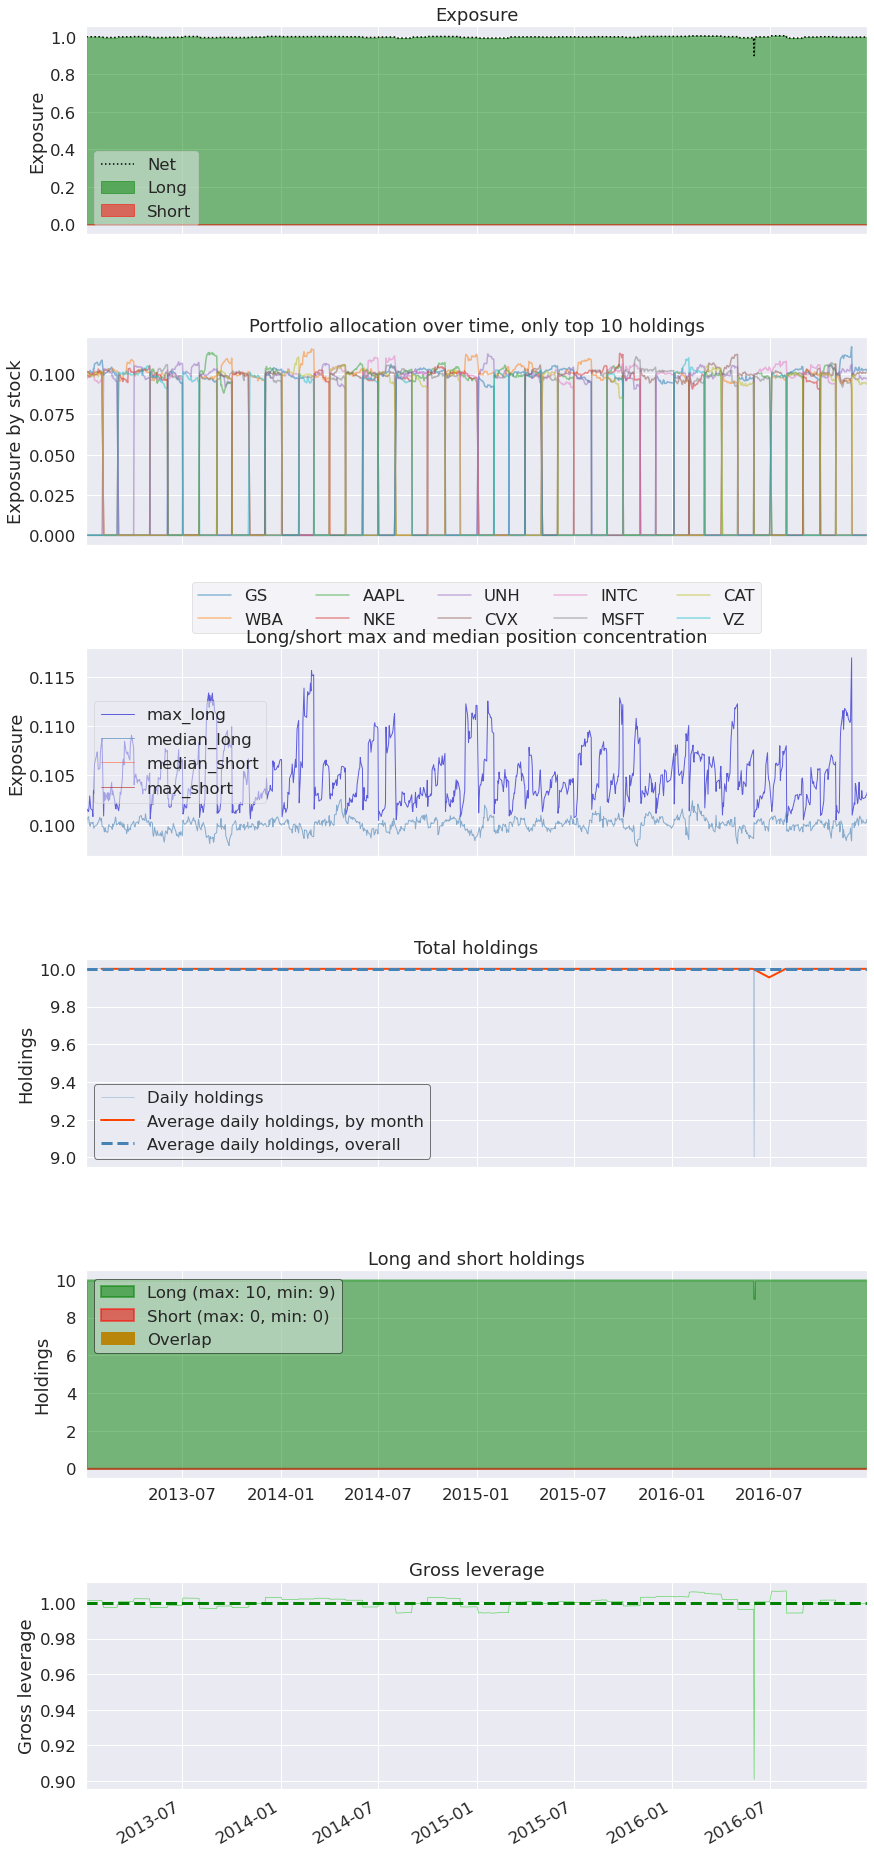

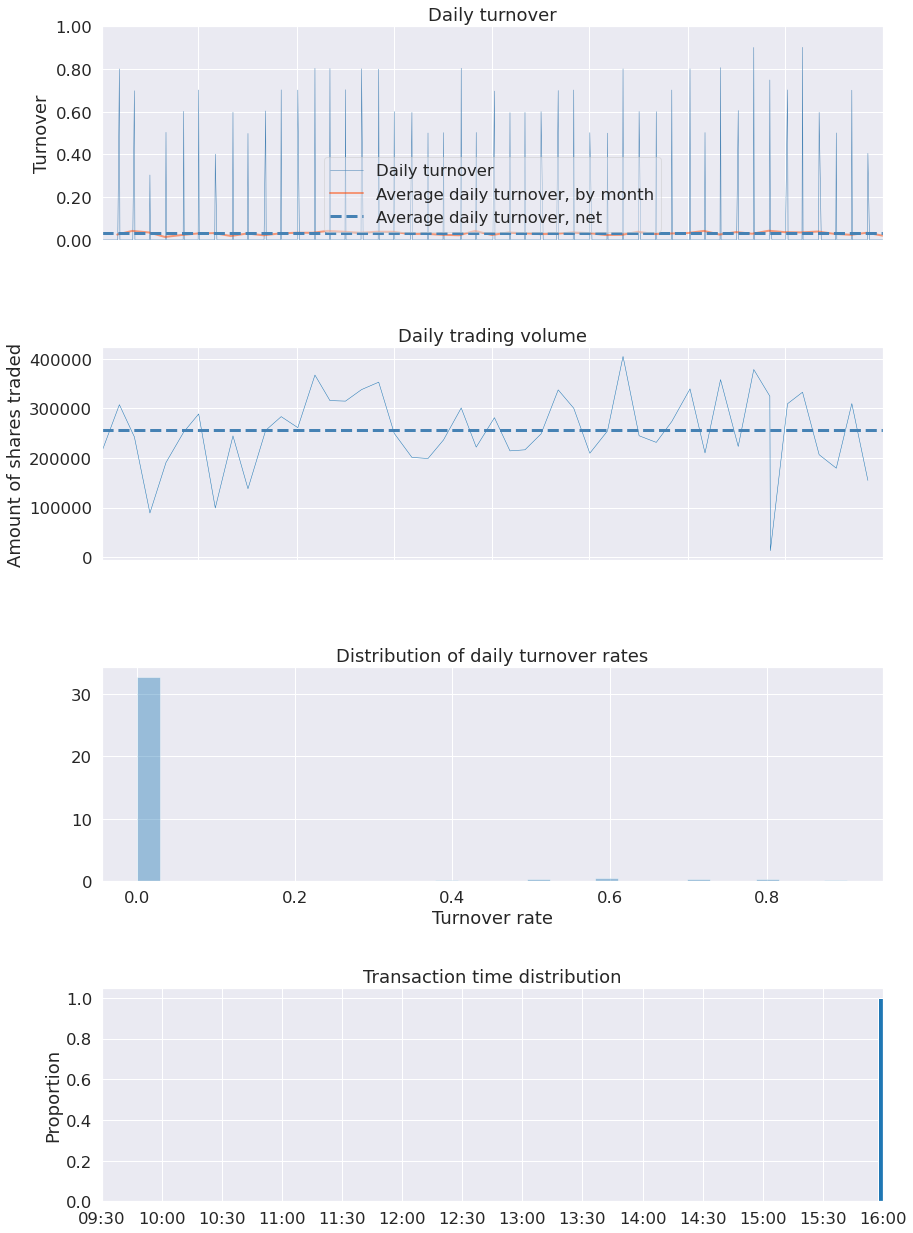

In [2]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol,  \
    schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd

def initialize(context):
    # Which stocks to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    
    # Make symbol list from tickers
    context.universe = [symbol(s) for s in dji]
    
    # History window
    context.history_window = 20
    
    # Size of our portfolio
    context.stocks_to_hold = 10
    
    # Schedule the daily trading routine for once per month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())    
    
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf
    
def handle_data(context, data):
    # Get history for all the stocks.
    hist = data.history(context.universe, "close", context.history_window, "1d")
    
    # This creates a table of percent returns, in order.
    perf_table = hist.apply(month_perf).sort_values(ascending=False)

    # Make buy list of the top N stocks
    buy_list = perf_table[:context.stocks_to_hold]
    
    # The rest will not be held.
    the_rest = perf_table[context.stocks_to_hold:]
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold

        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # Make sure we are flat the rest.
    for stock, perf in the_rest.iteritems():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)     
            
def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    # pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    start_ref = datetime(2013, 1, 1, 0, 0, 0, 0, pytz.utc)
    end_ref = datetime(2017, 1, 1, 0, 0, 0, 0, pytz.utc)
    benchmark_rets=pd.Series(0.78,index=pd.date_range(start_ref,end_ref), dtype="float64")
    pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_rets, positions=positions, transactions=transactions)
        

# Set start and end date
start = pd.Timestamp('2013-01-01', tz='utc')
end = pd.Timestamp('2017-01-01', tz='utc')

# Fire off the backtest
results = run_algorithm(
    start=start, 
    end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=10000, 
    data_frequency = 'daily', 
    bundle='quantopian-quandl' 
)
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# positions.to_csv('positions.csv')
# returns.to_csv('returns.csv')
# transactions.to_csv('transactions.csv')

# Make fake benchmark returns


# pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

# # just create a series with 0 returns
# start_ref = datetime(2013, 1, 1, 0, 0, 0, 0, pytz.utc)
# end_ref = datetime(2017, 1, 1, 0, 0, 0, 0, pytz.utc)
# benchmark_rets=pd.Series(0,index=pd.date_range(start_ref,end_ref), dtype="float64")
# pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_rets, positions=positions, transactions=transactions)
# pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')